In [1]:
import pandas as pd
import csv
import sqlite3
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
from plotly.offline import init_notebook_mode
plotly.offline.init_notebook_mode(connected=True)

In [2]:
#My initial dataset was 123MB and a file that big can not be pushed to github. I had to create a selection, specifically stats
#for the US and read them into a separate file for inclusion on Github. The commented out code below is the code I used
#to create my new file. The dataset itself came from the United Nations via Kaggle and includes energy production statistics
#from 1990-2014

#energy = pd.read_csv('all_energy_statistics.csv')

#energy.dropna()

#US_energy = energy['country_or_area'] == 'United States'

#test = energy[US_energy]

#test.to_csv(r'US_energy.csv', index = False)

#Read in my custom selection of data specific to US energy production

USA_energy = pd.read_csv('US_energy.csv')

USA_energy.head(3)

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,United States,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",2484.0,NaN,additives_and_oxygenates
1,United States,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",2640.0,NaN,additives_and_oxygenates
2,United States,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",2579.0,NaN,additives_and_oxygenates


In [3]:
#Read in the dataset provided by the National Energy Information Administration of NEIA of energy production by source and state
#from 1990-2018

by_state = pd.read_excel (r'annual_generation_state.xls', header=None)

#Label the columns something more human readable

by_state = by_state.rename(columns={0:"Year", 1:"State", 2:"Type_of_producer", 3:"Energy_Source", 4:"Generation(Megawatt_Hours)"})

#Dropping some columns of metadata that interfere with the visualization process

by_state = by_state.drop([0,1], axis=0)

by_state.head(3)

,Year,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
2,1990,AK,Total Electric Power Industry,Total,5599506
3,1990,AK,Total Electric Power Industry,Coal,510573
4,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521


In [55]:
heat = ((by_state['Energy_Source'] == 'Hydroelectric Conventional') | (by_state['Energy_Source'] == 'Solar Thermal and Photovoltaic')
| (by_state['Energy_Source'] == 'Wind') | (by_state['Energy_Source'] == 'Geothermal')) & (by_state['Type_of_producer'] == 
            "Total Electric Power Industry") & (by_state['Year'] == 2018)
heat = by_state[heat]

drop = []

drop.append(heat.index[heat['State'] == 'US-Total'])

for thing in drop:
    heat = heat.drop(index=thing)

data = [
    go.Heatmap(
        z=heat['Generation(Megawatt_Hours)'],
        x=heat['State'],
        y=heat['Energy_Source'],
        colorscale='Viridis',
    )
]
               
layout = go.Layout(
    title='Renewable Energy by Source and State in Megawatt-Hours',
    xaxis=dict(
        tickmode='linear',
        tickangle = 285
    ),
    width=1000,
    height=400
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, filename='State_heat_map.html', auto_open=False)
fig.show()

In [5]:
#states = by_state.State.unique()

#tot_us = states

#states

In [6]:
#Creation of a function to generate custom dataframe objects

def st_df_object(source, year):
    results = (by_state['Energy_Source'] == source) & (by_state['Type_of_producer'] == 
            "Total Electric Power Industry") & (by_state['Year'] == year)
    results = by_state[results]
    drop = results.index[results['State'] == 'US-Total']
    results = results.drop(index=drop)
    return results

In [7]:
#Filtering for 2018 Hydro generation by State

st_hydro = st_df_object('Hydroelectric Conventional', 2018)

st_hydro.head(3)

,Year,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
49523,2018,AK,Total Electric Power Industry,Hydroelectric Conventional,1664225
49557,2018,AL,Total Electric Power Industry,Hydroelectric Conventional,11143139
49594,2018,AR,Total Electric Power Industry,Hydroelectric Conventional,3008775


In [8]:
#Creation of a function to create plotly choropleth graphs

def plotly_choropleth(df, source):
    fig = go.Figure(data=go.Choropleth(
    locations=df['State'], # Spatial coordinates
    z = df['Generation(Megawatt_Hours)'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Megawatt Hours",
    ))

    fig.update_layout(
    title_text = '2018 ' + source + ' Generation by State',
    geo_scope='usa', # limite map scope to USA
    )

    pio.write_html(fig, file='State_' + source + '.html', auto_open=False)

    return fig.show()

In [9]:
#Creation of plotly US State Choropleth graph for Hydro Generation

plotly_choropleth(st_hydro, 'Hydroelectric')

In [10]:
#Filtering for 2018 Solar generation

st_solar = st_df_object('Solar Thermal and Photovoltaic', 2018)

st_solar.head(3)

,Year,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
49563,2018,AL,Total Electric Power Industry,Solar Thermal and Photovoltaic,357252
49599,2018,AR,Total Electric Power Industry,Solar Thermal and Photovoltaic,203413
49637,2018,AZ,Total Electric Power Industry,Solar Thermal and Photovoltaic,5140377


In [11]:
#Creation of plotly US State Choropleth graph for Solar Generation

plotly_choropleth(st_solar, 'Solar')

In [12]:
#Filtering for Wind

st_wind = st_df_object('Wind', 2018)

st_wind.head(3)

,Year,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
49528,2018,AK,Total Electric Power Industry,Wind,155015
49639,2018,AZ,Total Electric Power Industry,Wind,530190
49677,2018,CA,Total Electric Power Industry,Wind,14023951


In [13]:
#Creation of plotly US State Choropleth chart for Wind Generation

plotly_choropleth(st_wind, 'Wind')

In [14]:
#Filtering for Geothermal

st_geo = st_df_object('Geothermal', 2018)

st_geo.head(3)

,Year,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
49667,2018,CA,Total Electric Power Industry,Geothermal,11676841
49948,2018,HI,Total Electric Power Industry,Geothermal,110089
50033,2018,ID,Total Electric Power Industry,Geothermal,83112


In [15]:
#Creation of plotly US State Choropleth chart for Hydro Generation

plotly_choropleth(st_geo, 'Geothermal')

In [16]:
#This creates a custom dataframe of Ky renewables. Doing some googling about this Ky produces no documentable wind energy or 
#geothermal so the focus here is on hydro and solar. Ky didn't start showing documentable solar production until 2016.

#I'm performing the state analysis in Python and Pandas specifically foregoing SQL

ky = (by_state['State'] == "KY") & ((by_state['Energy_Source'] == "Solar Thermal and Photovoltaic") | 
     (by_state['Energy_Source'] == "Hydroelectric Conventional")) & (by_state['Type_of_producer'] == 
     "Total Electric Power Industry")

#This creates a dataset of Ky's total energy production for comparison and creation of a percentage of renewables vs the whole

ky_tot = (by_state['State'] == "KY") & (by_state['Energy_Source'] == "Total") & (by_state['Type_of_producer']
          == "Total Electric Power Industry")

ky = by_state[ky]

ky_tot = by_state[ky_tot]

ky.tail(5)

,Year,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
46016,2016,KY,Total Electric Power Industry,Solar Thermal and Photovoltaic,11732
48095,2017,KY,Total Electric Power Industry,Hydroelectric Conventional,4506018
48099,2017,KY,Total Electric Power Industry,Solar Thermal and Photovoltaic,19885
50195,2018,KY,Total Electric Power Industry,Hydroelectric Conventional,4417833
50199,2018,KY,Total Electric Power Industry,Solar Thermal and Photovoltaic,39436


In [17]:
ky_tot.tail(3)

,Year,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
46010,2016,KY,Total Electric Power Industry,Total,80273501
48093,2017,KY,Total Electric Power Industry,Total,73179196
50193,2018,KY,Total Electric Power Industry,Total,78804497


In [18]:
#The ky_ren variable is created for the purpose of getting a sum of Ky's renewable energy sources. When .sum() was called it was
#creating some strange behavior in non-numeric columns so the .replace() call was for ease of human reading of the dataframe

ky_ren = ky.groupby(['Year']).sum()

ky_ren = ky_ren.replace({'KYKY':'KY', 'Total Electric Power IndustryTotal Electric Power Industry':
                         'Total Electric Power Industry', 'Hydroelectric ConventionalSolar Thermal and Photovoltaic':
                         'Hydro and Solar'})

#The next line is commented out because it produces a columnn of 'NaN' values. Something to come back to

#ky_ren['ren_as_per'] = ky_ren['Generation(Megawatt_Hours)'] / ky_tot['Generation(Megawatt_Hours)']

ky_ren.tail(5)

,State,Type_of_producer,Energy_Source,Generation(Megawatt_Hours)
Year,,,,
2014,KY,Total Electric Power Industry,Hydroelectric Conventional,3143567
2015,KY,Total Electric Power Industry,Hydroelectric Conventional,3403481
2016,KY,Total Electric Power Industry,Hydro and Solar,3489662
2017,KY,Total Electric Power Industry,Hydro and Solar,4525903
2018,KY,Total Electric Power Industry,Hydro and Solar,4457269


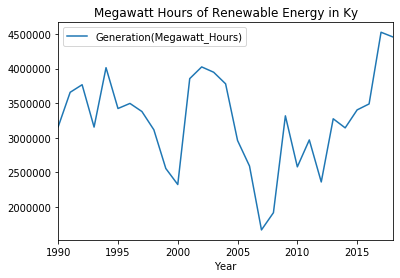

In [19]:
#Including matplotlib visualizations for now because they will preview on github. Plotly for whatever reason will not

ky_ren.plot(y='Generation(Megawatt_Hours)', title="Megawatt Hours of Renewable Energy in Ky")

In [20]:
#plotly visualization of renewable energy production in Ky by Megawatt Hour

ky_ren_pl = px.bar(ky, x='Year', y='Generation(Megawatt_Hours)', labels={'Generation(Megawatt_Hours)':'Megawatt Hours'},
                  title='Ky Renewables')

pio.write_html(ky_ren_pl, file='Ky_Renewables.html', auto_open=False)
              #'wind_as_per':'Percentage of Wind vs Total'}, hover_data=['wind_as_per'], color='wind_as_per',

ky_ren_pl.show()

In [21]:
#On to national statistics which I will be performing including SQL in addition to any pandas transformations. This data is
#purely US national data.

#Create database

db = sqlite3.connect("Energy.db")

#Read data into database

USA_energy.to_sql("Energy", db, if_exists="replace")

In [22]:
#Query to create a sampling of total US energy production for comparison and to create percentages by source 

tot_query = 'SELECT * FROM Energy WHERE commodity_transaction="Electricity - net production";'

tot_results = pd.read_sql_query(tot_query, db)

tot_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,18732,United States,Electricity - net production,2014,"Kilowatt-hours, million",4122391.0,None,total_electricity
1,18733,United States,Electricity - net production,2013,"Kilowatt-hours, million",4093401.0,None,total_electricity
2,18734,United States,Electricity - net production,2012,"Kilowatt-hours, million",4077151.0,None,total_electricity


In [23]:
#Creation of a function to create a dataset for a particular source of energy by passing a name and the energy source

def pd_object(name, category):
    query = "SELECT * FROM Energy WHERE category='" + category + "';"
    results = pd.read_sql_query(query, db)
    results[name + '_as_per'] =  results['quantity'] / tot_results['quantity'] * 100
    return results

In [24]:
#Wind energy dataframe

wind_results = pd_object('wind', 'wind_electricity')

wind_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,wind_as_per
0,19822,United States,Electricity - total wind production,2014,"Kilowatt-hours, million",183892.0,None,wind_electricity,4.460809
1,19823,United States,Electricity - total wind production,2013,"Kilowatt-hours, million",169713.0,None,wind_electricity,4.146015
2,19824,United States,Electricity - total wind production,2012,"Kilowatt-hours, million",141922.0,None,wind_electricity,3.480911


In [25]:
#Function for quantity matplotlib plots

def nat_quantity_plt(df, source):
    df.plot(x='year', y='quantity', title='Total ' + source + " in Kilowatt-hours: Millions")

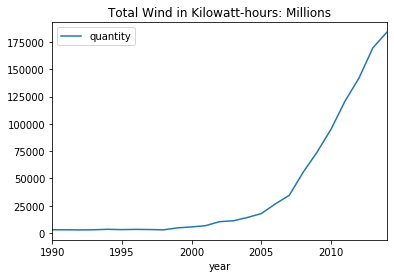

In [26]:
#Wind matplotlib

nat_quantity_plt(wind_results, "Wind")

In [27]:
#Function for source as a percentage of the whole matplotlib plots 

def nat_percentage_plt(df, column, source):
    df.plot(x='year', y=column, title='Total ' + source + ' Production as a Percentage of Total Energy Production')

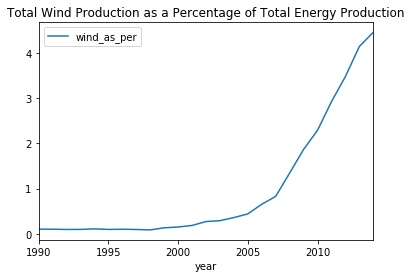

In [28]:
#Wind percentage matplotlib

nat_percentage_plt(wind_results, 'wind_as_per', 'Wind')

In [29]:
#Function for creation of plotly bar charts

def nat_bar_plotly(df, column, source, title):
    plot = px.bar(df, x='year', y='quantity', labels={'quantity':'Kilowatt-Hours in Millions', 'year':'Year', 
              column:'Percentage of ' + source + ' vs Total'}, hover_data=[column], color=column, 
              title=title + ' Energy Production')
    
    pio.write_html(plot, file='US_' + title + '.html', auto_open=False)
    
    plot.show()

In [30]:
#Wind plotly

nat_bar_plotly(wind_results, 'wind_as_per', 'Wind', 'Wind')

In [31]:
#Solar dataframe

sol_results = pd_object('sol', 'solar_electricity')

sol_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,sol_as_per
0,17359,United States,Electricity - total solar production,2014,"Kilowatt-hours, million",24603.0,None,solar_electricity,0.596814
1,17360,United States,Electricity - total solar production,2013,"Kilowatt-hours, million",15872.0,None,solar_electricity,0.387746
2,17361,United States,Electricity - total solar production,2012,"Kilowatt-hours, million",10145.0,None,solar_electricity,0.248826


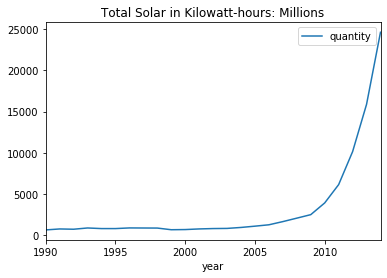

In [32]:
#Solar matplotlib

nat_quantity_plt(sol_results, "Solar")

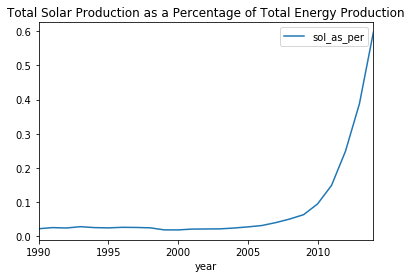

In [33]:
#Solar percentage matplotlib

nat_percentage_plt(sol_results, 'sol_as_per', 'Solar')

In [34]:
#Solar plotly

nat_bar_plotly(sol_results, 'sol_as_per', 'Solar', 'Solar')

In [35]:
#Hydro dataframe

hyd_results = pd_object('hyd', 'hydro')

hyd_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,hyd_as_per
0,9058,United States,Electricity - total hydro production,2014,"Kilowatt-hours, million",281527.0,None,hydro,6.829216
1,9059,United States,Electricity - total hydro production,2013,"Kilowatt-hours, million",290113.0,None,hydro,7.087334
2,9060,United States,Electricity - total hydro production,2012,"Kilowatt-hours, million",298287.0,None,hydro,7.316065


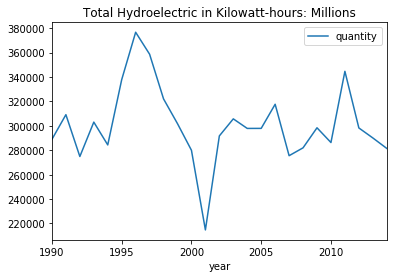

In [36]:
#Hydro matplotlib

nat_quantity_plt(hyd_results, "Hydroelectric")

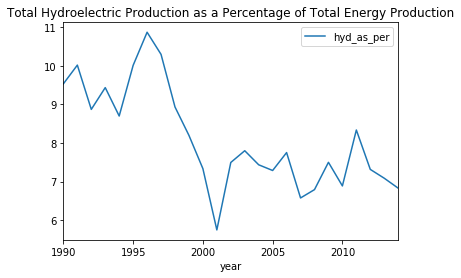

In [37]:
#Hydro percentage matplotlib

nat_percentage_plt(hyd_results, 'hyd_as_per', 'Hydroelectric')

In [38]:
#Hydro plotly

nat_bar_plotly(hyd_results, 'hyd_as_per', 'Hydroelectric', 'Hydroelectric')

In [39]:
#Geothermal dataframe

geo_results = pd_object('geo', 'geothermal')

geo_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,geo_as_per
0,7523,United States,Electricity - total geothermal production,2014,"Kilowatt-hours, million",18710.0,None,geothermal,0.453863
1,7524,United States,Electricity - total geothermal production,2013,"Kilowatt-hours, million",18422.0,None,geothermal,0.450041
2,7525,United States,Electricity - total geothermal production,2012,"Kilowatt-hours, million",18135.0,None,geothermal,0.444796


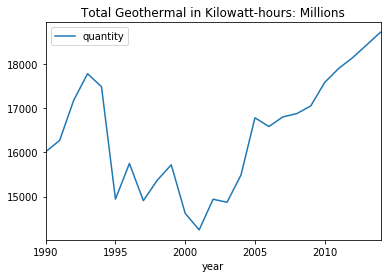

In [40]:
#Geothermal matplotlib

nat_quantity_plt(geo_results, "Geothermal")

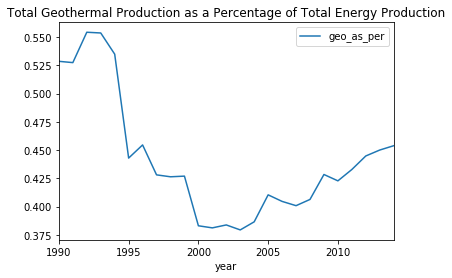

In [41]:
#Geothermal percentage matplotlib

nat_percentage_plt(geo_results, 'geo_as_per', 'Geothermal')

In [42]:
#Geothermal plotly

nat_bar_plotly(geo_results, 'geo_as_per', 'Geothermal', 'Geothermal')

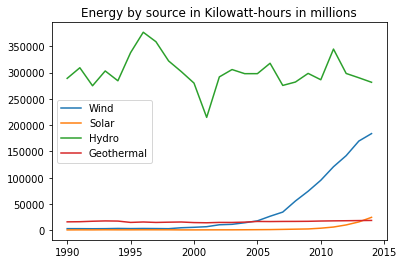

In [43]:
#Matplot lib visualization with all 4 renewable sources on one graph

plt.subplots()

plt.plot(wind_results['year'], wind_results['quantity'])

plt.plot(sol_results['year'], sol_results['quantity'])

plt.plot(hyd_results['year'], hyd_results['quantity'])

plt.plot(geo_results['year'], geo_results['quantity'])

plt.title("Energy by source in Kilowatt-hours in millions")

plt.legend(['Wind', 'Solar', 'Hydro', 'Geothermal'])

In [44]:
#Plotly visualization of 4 renewable energy sources on one bar chart 

fig = go.Figure(data=[
    go.Bar(name='Wind', x=wind_results['year'], y=wind_results['quantity']),
    go.Bar(name='Solar', x=sol_results['year'], y=sol_results['quantity']),
    go.Bar(name='Hydro', x=hyd_results['year'], y=hyd_results['quantity']),
    go.Bar(name='Geothermal', x=geo_results['year'], y=geo_results['quantity'])
])

# Change the bar mode
fig.update_layout(barmode='group')

fig.update_layout(title_text='Total Renewable Production by Source in Kilowatt-Hours:Millions')

fig.update_layout(barmode='group', xaxis_tickangle=-45)

pio.write_html(fig, file='US_Total_Renewable.html', auto_open=False)

fig.show()

In [45]:
#Calculates a percentage of renewables vs the whole column on the totals chart represented as 'ren_as_per'

tot_results['ren_as_per'] = (wind_results['quantity'] + sol_results['quantity'] + hyd_results['quantity'] + geo_results['quantity']) / tot_results['quantity'] * 100

tot_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,ren_as_per
0,18732,United States,Electricity - net production,2014,"Kilowatt-hours, million",4122391.0,None,total_electricity,12.340702
1,18733,United States,Electricity - net production,2013,"Kilowatt-hours, million",4093401.0,None,total_electricity,12.071136
2,18734,United States,Electricity - net production,2012,"Kilowatt-hours, million",4077151.0,None,total_electricity,11.490597


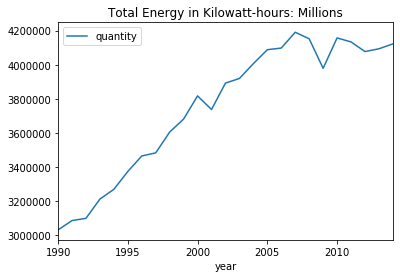

In [46]:
#Total energy production matplotlib

nat_quantity_plt(tot_results, 'Energy')

In [47]:
#Total plotly

nat_bar_plotly(tot_results, 'ren_as_per', 'Renewable', 'Total')

In [48]:
#distinct = 'SELECT category, COUNT(*) AS NUMBER_OF_ENTRIES FROM Energy GROUP BY category;'

#dis_show = pd.read_sql_query(distinct, db)

#with pd.option_context('display.max_rows', 1104):
    #display(dis_show)

In [49]:
db.close()